# **Human Motion Diffusion Model (MDM)**

---

**Overview:**

We will implement and analyze key components of the **Human Motion Diffusion Model (MDM)**, a state-of-the-art generative model for synthesizing realistic human motion sequences. This assignment combines theoretical derivations with hands-on implementation, culminating in the generation of motion sequences visualized as animated GIFs.

<br/>


---
## Part 1: Environment Setup
---

In [1]:
# Install required packages
!pip install -q torch torchvision torchaudio
!pip install -q matplotlib numpy scipy tqdm
!pip install -q imageio[ffmpeg] Pillow
!pip install -q einops

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import imageio
from tqdm import tqdm
import math
from typing import Optional, Tuple, List
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

torch.manual_seed(42)
np.random.seed(42)

Using device: cuda


---
## Part 2: Motion Data and Visualization 
---

In this section, We will work with synthetic motion data and implement visualization utilities.

In [3]:
# SKELETON DEFINITION (PROVIDED - DO NOT MODIFY)

JOINT_NAMES = [
    'pelvis', 'left_hip', 'right_hip', 'spine1', 'left_knee', 'right_knee',
    'spine2', 'left_ankle', 'right_ankle', 'spine3', 'left_foot', 'right_foot',
    'neck', 'left_collar', 'right_collar', 'head', 'left_shoulder', 'right_shoulder',
    'left_elbow', 'right_elbow', 'left_wrist', 'right_wrist'
]

PARENT_INDICES = [
    -1, 0, 0, 0, 1, 2,
    3, 4, 5, 6, 7, 8,
    9, 9, 9, 12, 13, 14,
    16, 17, 18, 19
]

NUM_JOINTS = len(JOINT_NAMES)

SKELETON_CONNECTIONS = [
    (0, 1), (0, 2), (0, 3),
    (1, 4), (2, 5),
    (4, 7), (5, 8),
    (7, 10), (8, 11),
    (3, 6), (6, 9),
    (9, 12), (12, 15),
    (9, 13), (9, 14),
    (13, 16), (14, 17),
    (16, 18), (17, 19),
    (18, 20), (19, 21)
]

# T-pose reference positions
T_POSE = np.array([
    [0, 0, 0],       # pelvis
    [-0.1, 0, 0],    # left_hip
    [0.1, 0, 0],     # right_hip
    [0, 0.1, 0],     # spine1
    [-0.1, -0.4, 0], # left_knee
    [0.1, -0.4, 0],  # right_knee
    [0, 0.25, 0],    # spine2
    [-0.1, -0.8, 0], # left_ankle
    [0.1, -0.8, 0],  # right_ankle
    [0, 0.4, 0],     # spine3
    [-0.1, -0.85, 0.05], # left_foot
    [0.1, -0.85, 0.05],  # right_foot
    [0, 0.55, 0],    # neck
    [-0.05, 0.5, 0], # left_collar
    [0.05, 0.5, 0],  # right_collar
    [0, 0.7, 0],     # head
    [-0.2, 0.45, 0], # left_shoulder
    [0.2, 0.45, 0],  # right_shoulder
    [-0.35, 0.25, 0], # left_elbow
    [0.35, 0.25, 0],  # right_elbow
    [-0.45, 0.05, 0], # left_wrist
    [0.45, 0.05, 0],  # right_wrist
], dtype=np.float32)

# Reference bone lengths (for post-processing)
BONE_LENGTHS = []
for (start, end) in SKELETON_CONNECTIONS:
    length = np.linalg.norm(T_POSE[end] - T_POSE[start])
    BONE_LENGTHS.append(length)
BONE_LENGTHS = np.array(BONE_LENGTHS, dtype=np.float32)

In [4]:
# These functions handle post-processing to ensure physically plausible outputs

def normalize_bone_lengths(motion: torch.Tensor, strength: float = 0.9) -> torch.Tensor:
    """
    Post-process motion to fix bone length artifacts from high CFG values.
    Iteratively adjusts joint positions to maintain correct bone lengths.

    Args:
        motion: (batch, seq_len, num_joints, 3) tensor
        strength: How strongly to enforce bone lengths (0-1)

    Returns:
        Corrected motion tensor
    """
    motion = motion.clone()
    ref_lengths = torch.tensor(BONE_LENGTHS, device=motion.device, dtype=motion.dtype)

    for _ in range(3):  # 3 iterations
        for idx, (parent, child) in enumerate(SKELETON_CONNECTIONS):
            bone_vec = motion[:, :, child] - motion[:, :, parent]
            current_length = torch.norm(bone_vec, dim=-1, keepdim=True) + 1e-8
            scale = strength * (ref_lengths[idx] / current_length) + (1 - strength)
            motion[:, :, child] = motion[:, :, parent] + bone_vec * scale

    return motion


def compute_dynamic_cfg_scale(
    guidance_scale: float,
    t: torch.Tensor,
    num_timesteps: int
) -> torch.Tensor:
    """
    Compute dynamic CFG scale that reduces at low noise levels.
    This prevents artifacts that occur when applying strong guidance
    to nearly-clean samples.

    At high t (lots of noise): returns full guidance_scale
    At low t (little noise): returns reduced guidance (~30% of original)

    Args:
        guidance_scale: Base guidance scale (e.g., 2.5 or 5.0)
        t: (batch,) current timesteps
        num_timesteps: Total number of diffusion steps

    Returns:
        (batch, 1, 1, 1) dynamic scale tensor for broadcasting
    """
    t_normalized = t.float() / num_timesteps
    return guidance_scale * (0.3 + 0.7 * t_normalized.view(-1, 1, 1, 1))


def clamp_motion(motion: torch.Tensor, max_dist: float = 1.2) -> torch.Tensor:
    """
    Clamp joint positions to reasonable bounds relative to pelvis.

    Args:
        motion: (batch, seq_len, num_joints, 3) tensor
        max_dist: Maximum distance from pelvis

    Returns:
        Clamped motion tensor
    """
    pelvis = motion[:, :, 0:1]
    relative = motion - pelvis
    relative = torch.clamp(relative, -max_dist, max_dist)
    return pelvis + relative

### Task 2.1: Synthetic Motion Generation

Implement a function to generate synthetic motion data representing different action types. This will serve as our training data for the simplified MDM.

**Skeleton Structure Reminder:**
- Joint 0 (pelvis): Root of the skeleton - controls overall body position
- Joints 3,6,9,12,15: Spine chain (spine1 → spine2 → spine3 → neck → head)
- Joints 1,4,7,10: Left leg (hip → knee → ankle → toe)
- Joints 2,5,8,11: Right leg (hip → knee → ankle → toe)
- Joints 13,16,18,20: Left arm (shoulder → elbow → wrist → hand)
- Joints 14,17,19,21: Right arm (shoulder → elbow → wrist → hand)

**Coordinate System:**
- X: Left/Right (negative = left)
- Y: Up/Down (positive = up)
- Z: Forward/Backward (positive = forward)

**Animation Pattern Example (for a single bouncing pelvis):**
```python
for i, ti in enumerate(t):
    phase = 2 * np.pi * frequency * ti  # Cyclic phase
    motion[i, 0] = [0, bounce_height * np.sin(phase), forward_speed * ti]
```

**Tips:**
- Use `np.sin()` and `np.cos()` for cyclic motions (legs, arms)
- Child joints should be positioned relative to parent joints
- Opposite limbs (left/right leg) should be in opposite phase (`phase + np.pi`)


In [5]:
def generate_synthetic_motion(
    action_type: str,
    num_frames: int = 60,
    fps: int = 20
) -> np.ndarray:
    """
    Generate synthetic motion data for different action types.

    Args:
        action_type: One of ['walk', 'run', 'jump', 'wave', 'sit']
        num_frames: Number of frames in the motion sequence
        fps: Frames per second

    Returns:
        motion: np.ndarray of shape (num_frames, num_joints, 3)
                representing 3D joint positions over time
    """
    t = np.linspace(0, num_frames / fps, num_frames)
    motion = np.zeros((num_frames, NUM_JOINTS, 3))

    # Initialize with T-pose for all frames
    motion[:] = T_POSE

    # Joint Indices
    # Left Leg: Hip(1), Knee(4), Ankle(7), Toe(10)
    # Right Leg: Hip(2), Knee(5), Ankle(8), Toe(11)
    # Left Arm: Shoulder(16), Elbow(18), Wrist(20)
    # Right Arm: Shoulder(17), Elbow(19), Wrist(21)
    # Spine: 3, 6, 9, 12, 15
    pelvis_idx = 0
    left_leg_indices = [1, 4, 7, 10]
    right_leg_indices = [2, 5, 8, 11]
    left_arm_indices = [16, 18, 20]
    right_arm_indices = [17, 19, 21]

    if action_type == 'walk':
        # Walking Parameters
        freq = 1.5
        stride_length = 0.3
        bounce = 0.03
        velocity = 0.5

        for i, ti in enumerate(t):
            phase = 2 * np.pi * freq * ti

            # Root translation (forward Z) and bounce (Y)
            root_offset = np.array([0, bounce * np.sin(2 * phase), velocity * ti])

            # Apply root offset to all joints
            motion[i] += root_offset

            # Legs: Inverse kinematics approximation via sine waves
            # Left leg
            motion[i, left_leg_indices, 2] += stride_length * np.sin(phase)
            motion[i, left_leg_indices, 1] += 0.1 * np.maximum(0, np.sin(phase)) # Lift foot

            # Right leg (opposite phase)
            motion[i, right_leg_indices, 2] += stride_length * np.sin(phase + np.pi)
            motion[i, right_leg_indices, 1] += 0.1 * np.maximum(0, np.sin(phase + np.pi))

            # Arms: Swing opposite to legs
            motion[i, left_arm_indices, 2] += 0.2 * np.sin(phase + np.pi)
            motion[i, right_arm_indices, 2] += 0.2 * np.sin(phase)

    elif action_type == 'run':
        # Running Parameters
        freq = 2.5
        stride_length = 0.6
        bounce = 0.08
        velocity = 2.0

        for i, ti in enumerate(t):
            phase = 2 * np.pi * freq * ti

            # Root translation and higher bounce
            root_offset = np.array([0, bounce * np.sin(2 * phase), velocity * ti])
            motion[i] += root_offset

            # Forward lean (rotate spine/upper body slightly forward)
            # Simplified as Z-offset increasing up the chain
            for j in [3, 6, 9, 12, 15]: # Spine joints
                motion[i, j, 2] += 0.15

            # Legs: Larger strides, higher lift
            motion[i, left_leg_indices, 2] += stride_length * np.sin(phase)
            motion[i, left_leg_indices, 1] += 0.25 * np.maximum(0, np.sin(phase))

            motion[i, right_leg_indices, 2] += stride_length * np.sin(phase + np.pi)
            motion[i, right_leg_indices, 1] += 0.25 * np.maximum(0, np.sin(phase + np.pi))

            # Arms: More pronounced swing
            motion[i, left_arm_indices, 1] += 0.2  # Arms held higher
            motion[i, right_arm_indices, 1] += 0.2
            motion[i, left_arm_indices, 2] += 0.4 * np.sin(phase + np.pi)
            motion[i, right_arm_indices, 2] += 0.4 * np.sin(phase)

    elif action_type == 'jump':
        # Jump logic based on time progress
        duration = t[-1]

        for i, ti in enumerate(t):
            progress = ti / duration

            # 1. Crouch (0-30%)
            if progress < 0.3:
                # Interpolate from 0 to -0.2
                crouch_depth = -0.2 * np.sin((progress / 0.3) * (np.pi / 2))
                motion[i, :, 1] += crouch_depth
                # Knees bend forward slightly (Z)
                motion[i, [4, 5], 2] += 0.1 * (progress / 0.3)

            # 2. Launch/Air (30-80%)
            elif progress < 0.8:
                # Parabolic arc
                air_phase = (progress - 0.3) / 0.5
                height = 0.8 * np.sin(air_phase * np.pi)
                motion[i, :, 1] += height

                # Raise arms
                arm_lift = 0.5 * np.sin(air_phase * np.pi)
                motion[i, left_arm_indices, 1] += arm_lift
                motion[i, right_arm_indices, 1] += arm_lift

            # 3. Landing (80-100%)
            else:
                land_phase = (progress - 0.8) / 0.2
                # Compress down
                crouch_depth = -0.15 * np.sin(land_phase * np.pi)
                motion[i, :, 1] += crouch_depth

    elif action_type == 'wave':
        # Waving parameters
        freq = 3.0

        for i, ti in enumerate(t):
            phase = 2 * np.pi * freq * ti

            # Body sway
            sway = 0.05 * np.sin(phase * 0.5)
            motion[i, :, 0] += sway

            # Right arm setup (raise shoulder/elbow)
            motion[i, right_arm_indices, 1] += 0.3 # Lift whole arm
            motion[i, 19, 0] += 0.2 # Elbow out
            motion[i, 21, 1] += 0.3 # Wrist up

            # Wave action (Wrist moves X/Y)
            motion[i, 21, 0] += 0.15 * np.sin(phase) # Side to side
            motion[i, 21, 1] += 0.05 * np.cos(phase) # Slight up/down arc

    elif action_type == 'sit':
        # Sit parameters
        duration = t[-1]
        target_height = -0.45

        for i, ti in enumerate(t):
            # Smooth step function (sigmoid-like)
            prog = min(1.0, ti / (duration * 0.8))
            smooth_step = prog * prog * (3 - 2 * prog) # Ease-in-out

            # Lower pelvis
            drop = target_height * smooth_step
            motion[i, :, 1] += drop

            # Move pelvis back
            motion[i, :, 2] -= 0.2 * smooth_step

            # Keep feet planted (inverse offset)
            # Feet indices: 10 (L_Toe), 11 (R_Toe), 7 (L_Ankle), 8 (R_Ankle)
            feet_indices = [7, 8, 10, 11]
            motion[i, feet_indices, 1] -= drop # Cancel vertical drop
            motion[i, feet_indices, 2] += 0.2 * smooth_step # Cancel backward move

            # Move knees forward
            motion[i, [4, 5], 2] += 0.3 * smooth_step

            # Hands on laps
            motion[i, left_arm_indices, 2] += 0.3 * smooth_step
            motion[i, right_arm_indices, 2] += 0.3 * smooth_step
            motion[i, left_arm_indices, 1] -= 0.1 * smooth_step
            motion[i, right_arm_indices, 1] -= 0.1 * smooth_step

    else:
        raise ValueError(f"Unknown action type: {action_type}")

    return motion.astype(np.float32)

In [6]:
walk_motion = generate_synthetic_motion("walk")
print(f"Walking motion shape: {walk_motion.shape}")
print(f"Expected: (60, 22, 3)")

if walk_motion.shape == (60, 22, 3):
    print("Shape correct")
else:
    print("Shape incorrect")


Walking motion shape: (60, 22, 3)
Expected: (60, 22, 3)
Shape correct


### Task 2.2: Motion Visualization as GIF

Implement a function to visualize motion sequences as animated GIFs.

In [20]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import imageio
import io

def visualize_motion_as_gif(
    motion: np.ndarray,
    filename: str = 'motion.gif',
    fps: int = 20,
    title: str = '',
    elevation: int = 15,
    azimuth: int = 45
) -> str:
    """
    Visualize a motion sequence as an animated GIF.

    Args:
        motion: np.ndarray of shape (num_frames, num_joints, 3)
        filename: Output GIF filename
        fps: Frames per second for the GIF
        title: Title for the animation
        elevation: Camera elevation angle
        azimuth: Camera azimuth angle

    Returns:
        filename: Path to the saved GIF
    """
    num_frames = motion.shape[0]
    frames = []

    # Define joint colors
    # Center/Torso: Pelvis, Spines, Neck, Head
    center_indices = [0, 3, 6, 9, 12, 15]
    # Left: Hip, Knee, Ankle, Foot, Collar, Shoulder, Elbow, Wrist
    left_indices = [1, 4, 7, 10, 13, 16, 18, 20]
    # Right: Hip, Knee, Ankle, Foot, Collar, Shoulder, Elbow, Wrist
    right_indices = [2, 5, 8, 11, 14, 17, 19, 21]

    # 1. Calculate axis bounds from motion data to keep scale consistent
    # We find the global min/max across all frames so the camera doesn't jitter
    all_x = motion[:, :, 0]
    all_y = motion[:, :, 1]
    all_z = motion[:, :, 2]

    # Calculate global range + padding
    mid_x = (np.max(all_x) + np.min(all_x)) / 2
    mid_y = (np.max(all_y) + np.min(all_y)) / 2
    mid_z = (np.max(all_z) + np.min(all_z)) / 2

    # Find the maximum radius to create a cubic bounding box
    max_range = np.array([
        np.max(all_x) - np.min(all_x),
        np.max(all_y) - np.min(all_y),
        np.max(all_z) - np.min(all_z)
    ]).max() / 2.0

    padding = 0.1
    limit = max_range + padding

    print(f"Generating GIF '{filename}' ({num_frames} frames)...")

    for i in range(num_frames):
        # 2a. Create 3D figure
        fig = plt.figure(figsize=(6, 6))
        ax = fig.add_subplot(111, projection='3d')

        # Current frame pose
        pose = motion[i]

        # 2c. Plot bones as lines
        for start, end in SKELETON_CONNECTIONS:
            xs = [pose[start, 0], pose[end, 0]]
            ys = [pose[start, 1], pose[end, 1]]
            zs = [pose[start, 2], pose[end, 2]]
            ax.plot(xs, zs, ys, color='gray', linewidth=2) # Note: Z is up in Mplot3d usually, but data is Y-up.
                                                           # Swapping Y/Z in plot args (xs, zs, ys) makes it look upright in standard matplotlib view.

        # 2b. Plot joints as scatter points
        # Plot Center (Blue)
        ax.scatter(pose[center_indices, 0], pose[center_indices, 2], pose[center_indices, 1],
                   c='blue', s=20, label='Center')
        # Plot Left (Green)
        ax.scatter(pose[left_indices, 0], pose[left_indices, 2], pose[left_indices, 1],
                   c='green', s=20, label='Left')
        # Plot Right (Red)
        ax.scatter(pose[right_indices, 0], pose[right_indices, 2], pose[right_indices, 1],
                   c='red', s=20, label='Right')

        # 2d. Set axis limits, labels, view angle
        # Centering the view around the calculated midpoints
        ax.set_xlim(mid_x - limit, mid_x + limit)
        ax.set_ylim(mid_z - limit, mid_z + limit) # Swapped Y/Z for plotting
        ax.set_zlim(mid_y - limit, mid_y + limit)

        ax.set_xlabel('X')
        ax.set_ylabel('Z')
        ax.set_zlabel('Y')
        ax.set_title(f"{title} (Frame {i}/{num_frames})")

        ax.view_init(elev=elevation, azim=azimuth)

        # Remove grid/ticks for cleaner look
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])

        # 2e. Convert figure to image array
        fig.canvas.draw()

        # Extract image from canvas buffer
        image = np.asarray(fig.canvas.buffer_rgba())
        frames.append(image)

        plt.close(fig)

    # 3. Save frames as GIF
    imageio.mimsave(filename, frames, fps=fps)
    print(f"Saved: {filename}")

    return filename

In [8]:
# Reference visualization implementation (PROVIDED)
def visualize_motion_as_gif_reference(
    motion: np.ndarray,
    filename: str = 'motion.gif',
    fps: int = 20,
    title: str = '',
    elevation: int = 15,
    azimuth: int = 45
) -> str:
    """Reference implementation for motion visualization."""
    num_frames = motion.shape[0]
    frames = []

    x_min, x_max = motion[:, :, 0].min() - 0.3, motion[:, :, 0].max() + 0.3
    y_min, y_max = motion[:, :, 1].min() - 0.3, motion[:, :, 1].max() + 0.3
    z_min, z_max = motion[:, :, 2].min() - 0.3, motion[:, :, 2].max() + 0.3

    max_range = max(x_max - x_min, y_max - y_min, z_max - z_min) / 2
    x_mid, y_mid, z_mid = (x_max + x_min) / 2, (y_max + y_min) / 2, (z_max + z_min) / 2

    torso_idx = [0, 3, 6, 9, 12, 15]
    left_idx = [1, 4, 7, 10, 13, 16, 18, 20]
    right_idx = [2, 5, 8, 11, 14, 17, 19, 21]

    for frame_idx in tqdm(range(num_frames), desc="Rendering"):
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111, projection='3d')

        joints = motion[frame_idx]

        ax.scatter(joints[torso_idx, 0], joints[torso_idx, 2], joints[torso_idx, 1], c='blue', s=60)
        ax.scatter(joints[left_idx, 0], joints[left_idx, 2], joints[left_idx, 1], c='green', s=50)
        ax.scatter(joints[right_idx, 0], joints[right_idx, 2], joints[right_idx, 1], c='red', s=50)

        for (start, end) in SKELETON_CONNECTIONS:
            if start in left_idx or end in left_idx:
                color = 'green'
            elif start in right_idx or end in right_idx:
                color = 'red'
            else:
                color = 'blue'
            ax.plot3D([joints[start, 0], joints[end, 0]],
                      [joints[start, 2], joints[end, 2]],
                      [joints[start, 1], joints[end, 1]],
                      color=color, linewidth=2.5)

        ax.set_xlim([x_mid - max_range, x_mid + max_range])
        ax.set_ylim([z_mid - max_range, z_mid + max_range])
        ax.set_zlim([y_mid - max_range, y_mid + max_range])
        ax.view_init(elev=elevation, azim=azimuth)
        ax.set_title(f"{title} - Frame {frame_idx + 1}/{num_frames}")

        fig.canvas.draw()
        image = np.asarray(fig.canvas.buffer_rgba())
        frames.append(image)
        plt.close(fig)

    imageio.mimsave(filename, frames, fps=fps, loop=0)
    print(f"Saved: {filename}")
    return filename

visualize_motion_as_gif_reference(walk_motion, 'walk_test.gif', title='Walking')

Rendering: 100%|██████████| 60/60 [00:09<00:00,  6.38it/s]


Saved: walk_test.gif


'walk_test.gif'

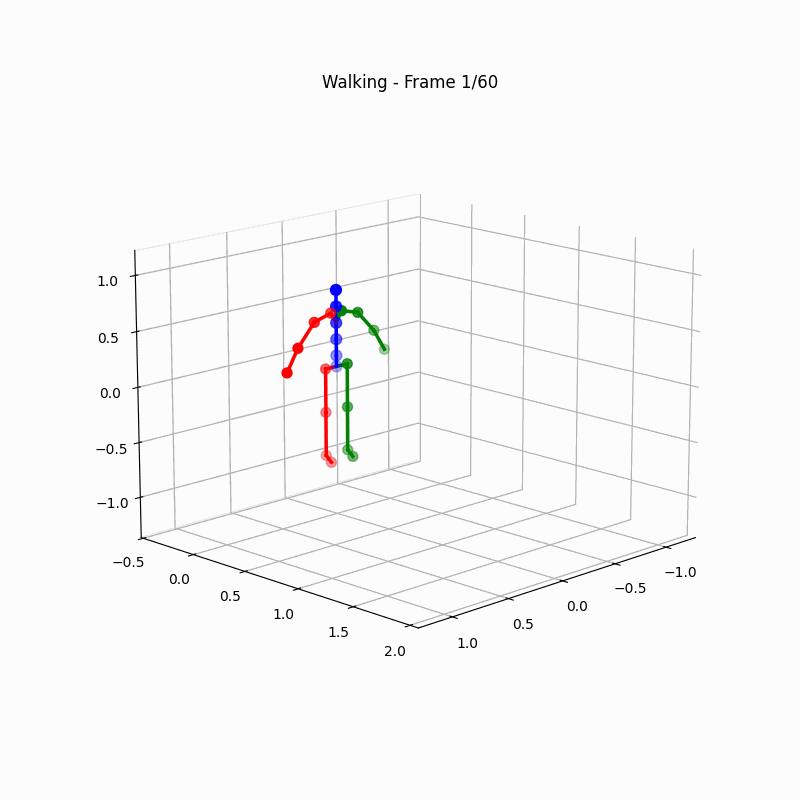

In [9]:
# Display the GIF
from IPython.display import Image as IPyImage, display
display(IPyImage(filename='walk_test.gif'))

### Task 2.3: Motion Features

Implement functions to compute motion features used in MDM's geometric losses.

In [10]:
def compute_velocity(motion: torch.Tensor) -> torch.Tensor:
    """
    Compute joint velocities from position sequence.

    Args:
        motion: (batch, frames, joints, 3) tensor of joint positions

    Returns:
        velocity: (batch, frames-1, joints, 3) tensor of velocities
    """
    
    return motion[:, 1:] - motion[:, :-1]


def compute_acceleration(motion: torch.Tensor) -> torch.Tensor:
    """
    Compute joint accelerations from position sequence.

    Args:
        motion: (batch, frames, joints, 3) tensor of joint positions

    Returns:
        acceleration: (batch, frames-2, joints, 3) tensor of accelerations
    """
    
    return motion[:, 2:] - 2 * motion[:, 1:-1] + motion[:, :-2]


def compute_foot_contact(
    motion: torch.Tensor,
    left_foot_idx: int = 10,
    right_foot_idx: int = 11,
    height_threshold: float = 0.05,
    velocity_threshold: float = 0.02
) -> torch.Tensor:
    """
    Compute binary foot contact labels.
    A foot is in contact when both:
    1. Its height (Y) is below threshold
    2. Its velocity magnitude is below threshold

    Args:
        motion: (batch, frames, joints, 3) tensor

    Returns:
        contact: (batch, frames, 2) binary tensor [left, right]
    """

    # Extract feet positions: (batch, frames, 2, 3)
    feet_indices = [left_foot_idx, right_foot_idx]
    feet_pos = motion[:, :, feet_indices]

    # 1. Calculate Velocity (magnitude)
    # We use forward differences: v[t] = x[t+1] - x[t]
    # Result has shape (batch, frames-1, 2, 3)
    feet_vel = feet_pos[:, 1:] - feet_pos[:, :-1]

    # Pad to match original number of frames (replicate last velocity)
    # Shape becomes (batch, frames, 2, 3)
    padding = feet_vel[:, -1:]
    feet_vel = torch.cat([feet_vel, padding], dim=1)

    # Compute velocity magnitude: (batch, frames, 2)
    vel_mag = torch.norm(feet_vel, dim=-1)

    # 2. Get Heights (Y coordinate is index 1)
    # Shape: (batch, frames, 2)
    feet_height = feet_pos[..., 1]

    # 3. Determine Contact
    contact = (feet_height < height_threshold) & (vel_mag < velocity_threshold)

    return contact.float()

---
## Part 3: MDM Architecture Implementation
---

In this section, we will implement the core components of the Motion Diffusion Model.

### Task 3.1: Positional Encodings 

In [11]:
class SinusoidalPositionalEncoding(nn.Module):
    """
    Sinusoidal positional encoding for diffusion timesteps and sequence positions.
    """
    def __init__(self, dim: int, max_len: int = 5000):
        super().__init__()
        self.dim = dim

        # ============================================================
        # Create positional encoding matrix of shape (max_len, dim)
        # PE(pos, 2i) = sin(pos / 10000^(2i/dim))
        # PE(pos, 2i+1) = cos(pos / 10000^(2i/dim))
        # Register as buffer using self.register_buffer('pe', pe)
        # ============================================================
        pe = torch.zeros(max_len, dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, dim, 2).float() * (-np.log(10000.0) / dim))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe)

    def forward(self, positions: torch.Tensor) -> torch.Tensor:
        """Return positional encodings for given positions."""
    
        return self.pe[positions]


class TimestepEmbedding(nn.Module):
    """
    Timestep embedding: sinusoidal encoding + MLP.
    """
    def __init__(self, dim: int, hidden_dim: int = None):
        super().__init__()
        hidden_dim = hidden_dim or dim * 4

        # ============================================================
        # 1. Create SinusoidalPositionalEncoding
        # 2. Create MLP: Linear(dim, hidden) -> SiLU -> Linear(hidden, dim)
        # ============================================================
        self.pe = SinusoidalPositionalEncoding(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, dim)
        )

    def forward(self, timesteps: torch.Tensor) -> torch.Tensor:
        
        # Ensure timesteps are long type for indexing
        emb = self.pe(timesteps.long())
        return self.mlp(emb)

### Task 3.2: Transformer Encoder Block 

In [12]:
class TransformerEncoderBlock(nn.Module):
    """
    Pre-norm transformer encoder block.

    Structure:
    x -> LayerNorm -> MultiHeadAttention -> + -> LayerNorm -> MLP -> +
    |___________________________________|   |___________________|
                  (residual)                       (residual)
    """
    def __init__(
        self,
        dim: int,
        num_heads: int = 8,
        mlp_ratio: float = 4.0,
        dropout: float = 0.1
    ):
        super().__init__()

        # ============================================================
        # 1. Two LayerNorm layers
        # 2. MultiheadAttention (use batch_first=True)
        # 3. MLP: Linear -> GELU -> Dropout -> Linear -> Dropout
        # 4. Dropout for residual
        # ============================================================
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)

        self.attn = nn.MultiheadAttention(dim, num_heads, dropout=dropout, batch_first=True)

        hidden_dim = int(dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

        # Dropout for the attention residual connection
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor, mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        """
        Args:
            x: (batch, seq_len, dim)
            mask: Optional attention mask
        """
    
        # 1. Attention block (Pre-norm)
        # Norm -> Attn -> Drop -> Add
        x_norm = self.norm1(x)
        attn_out, _ = self.attn(
            x_norm, x_norm, x_norm,
            key_padding_mask=mask,
            need_weights=False
        )
        x = x + self.dropout(attn_out)

        # 2. MLP block (Pre-norm)
        # Norm -> MLP -> Add (MLP contains its own dropout at the end)
        x_norm = self.norm2(x)
        mlp_out = self.mlp(x_norm)
        x = x + mlp_out

        return x

### Task 3.3: Motion Diffusion Model 

In [13]:
class MotionDiffusionModel(nn.Module):
    """
    Motion Diffusion Model (MDM) for human motion generation.

    Architecture:
    1. Input projection: flatten joints -> hidden_dim
    2. Add temporal positional encoding
    3. Add timestep embedding (broadcast to all frames)
    4. Add action embedding with classifier-free masking
    5. Stack of transformer encoder blocks
    6. Output projection: hidden_dim -> flatten joints
    """
    def __init__(
        self,
        num_joints: int = 22,
        joint_dim: int = 3,
        hidden_dim: int = 256,
        num_layers: int = 6,
        num_heads: int = 4,
        num_actions: int = 5,
        max_seq_len: int = 196,
        dropout: float = 0.1,
        cond_mask_prob: float = 0.1  # Probability of masking condition for CFG
    ):
        super().__init__()

        self.num_joints = num_joints
        self.joint_dim = joint_dim
        self.motion_dim = num_joints * joint_dim
        self.hidden_dim = hidden_dim
        self.cond_mask_prob = cond_mask_prob
        self.num_actions = num_actions
        self.null_action_idx = num_actions # Index for the null/unconditional token

        # ============================================================
        # 1. input_proj: Linear(motion_dim, hidden_dim)
        # 2. output_proj: LayerNorm -> Linear(hidden_dim, motion_dim)
        # 3. timestep_emb: TimestepEmbedding
        # 4. action_emb: Embedding(num_actions + 1, hidden_dim)
        #    Note: +1 for null token used in classifier-free guidance
        # 5. pos_enc: SinusoidalPositionalEncoding
        # 6. blocks: ModuleList of TransformerEncoderBlock
        #
        # Store null_action_idx = num_actions for CFG
        # ============================================================
        self.input_proj = nn.Linear(self.motion_dim, hidden_dim)

        self.output_proj = nn.Sequential(
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, self.motion_dim)
        )

        self.timestep_emb = TimestepEmbedding(hidden_dim)

        # Embedding size is num_actions + 1 to include the null token
        self.action_emb = nn.Embedding(num_actions + 1, hidden_dim)

        self.pos_enc = SinusoidalPositionalEncoding(hidden_dim, max_len=max_seq_len)

        self.blocks = nn.ModuleList([
            TransformerEncoderBlock(hidden_dim, num_heads=num_heads, dropout=dropout)
            for _ in range(num_layers)
        ])

    def forward(
        self,
        x: torch.Tensor,
        timesteps: torch.Tensor,
        action: Optional[torch.Tensor] = None,
        mask: Optional[torch.Tensor] = None,
        force_mask: bool = False
    ) -> torch.Tensor:
        """
        Args:
            x: (batch, seq_len, num_joints, joint_dim) noisy motion
            timesteps: (batch,) diffusion timesteps
            action: (batch,) action class indices
            mask: Optional sequence mask
            force_mask: If True, use null embedding (for CFG)

        Returns:
            x0_pred: (batch, seq_len, num_joints, joint_dim) predicted clean motion
        """
        batch_size, seq_len = x.shape[:2]

        # Flatten joints: (batch, seq, joints, 3) -> (batch, seq, joints*3)
        x = x.view(batch_size, seq_len, -1)

        # ============================================================
        # 1. Project input: h = input_proj(x)
        # 2. Add positional encoding (for seq positions 0 to seq_len-1)
        # 3. Add timestep embedding (unsqueeze to broadcast)
        # 4. Handle action embedding with classifier-free masking:
        #    - If force_mask: always use null embedding
        #    - If training: randomly replace action with null (prob=cond_mask_prob)
        #    - Add action embedding (unsqueeze to broadcast)
        # 5. Pass through transformer blocks
        # 6. Output projection and reshape to (batch, seq, joints, 3)
        # ============================================================

        # 1. Project input
        h = self.input_proj(x)

        # 2. Add positional encoding
        positions = torch.arange(seq_len, device=x.device)
        h = h + self.pos_enc(positions)

        # 3. Add timestep embedding
        # (batch, hidden) -> (batch, 1, hidden)
        ts_emb = self.timestep_emb(timesteps).unsqueeze(1)
        h = h + ts_emb

        # 4. Handle action embedding with CFG
        if action is not None:
            # Clone to avoid modifying original tensor
            current_action = action.clone()

            # Logic for replacing labels with null token
            if force_mask:
                # Used during sampling for the unconditional branch
                current_action[:] = self.null_action_idx
            elif self.training and self.cond_mask_prob > 0:
                # Used during training to learn unconditional generation
                mask_indices = torch.rand(batch_size, device=x.device) < self.cond_mask_prob
                current_action[mask_indices] = self.null_action_idx

            # (batch, hidden) -> (batch, 1, hidden)
            act_emb = self.action_emb(current_action).unsqueeze(1)
            h = h + act_emb
        elif force_mask:
             # Case where action is None but we force mask (pure unconditional)
             current_action = torch.full((batch_size,), self.null_action_idx,
                                       device=x.device, dtype=torch.long)
             act_emb = self.action_emb(current_action).unsqueeze(1)
             h = h + act_emb

        # 5. Transformer blocks
        for block in self.blocks:
            h = block(h, mask)

        # 6. Output projection
        out = self.output_proj(h)

        # Reshape back to joint structure
        return out.view(batch_size, seq_len, self.num_joints, self.joint_dim)

---
## Part 4: Diffusion Training and Sampling 
---

### Task 4.1: Gaussian Diffusion Process 

In [14]:
class GaussianDiffusion:
    """
    Gaussian diffusion process with cosine noise schedule.
    """
    def __init__(
        self,
        num_timesteps: int = 1000,
        schedule: str = 'cosine',
        s: float = 0.008
    ):
        self.num_timesteps = num_timesteps

        # ============================================================
        # 1. Implement cosine schedule
        # 2. Compute and store pre-calculated terms
        # ============================================================
        if schedule == 'cosine':
            # Generate steps 0 to T
            steps = torch.arange(num_timesteps + 1, dtype=torch.float64) / num_timesteps

            # f(t) calculation
            alpha_bar = torch.cos(((steps + s) / (1 + s)) * (np.pi / 2)) ** 2
            alpha_bar = alpha_bar / alpha_bar[0]  # f(t) / f(0)

            # Beta calculation: beta_t = 1 - alpha_bar_t / alpha_bar_{t-1}
            betas = 1 - (alpha_bar[1:] / alpha_bar[:-1])

            # Clip betas to prevent numerical instability at t=T
            betas = torch.clamp(betas, min=0.0001, max=0.9999)

        elif schedule == 'linear':
            # Standard linear schedule for reference (optional but good practice)
            scale = 1000 / num_timesteps
            beta_start = scale * 0.0001
            beta_end = scale * 0.02
            betas = torch.linspace(beta_start, beta_end, num_timesteps, dtype=torch.float64)
        else:
            raise NotImplementedError(f"Schedule {schedule} not implemented")

        # Convert everything to float32 for model usage
        self.betas = betas.float()
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.alphas_cumprod_prev = torch.cat([torch.tensor([1.0]), self.alphas_cumprod[:-1]])

        # Calculations for diffusion q(x_t | x_0)
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)

        # Calculations for posterior q(x_{t-1} | x_t, x_0)
        # Variance: beta * (1 - alpha_cumprod_prev) / (1 - alpha_cumprod)
        self.posterior_variance = (
            self.betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
        # Log variance (clipped to avoid log(0) at t=0)
        self.posterior_log_variance_clipped = torch.log(
            torch.clamp(self.posterior_variance, min=1e-20)
        )

        # Mean coefficients:
        # coef1 = beta * sqrt(alpha_cumprod_prev) / (1 - alpha_cumprod)
        # coef2 = (1 - alpha_cumprod_prev) * sqrt(alpha) / (1 - alpha_cumprod)
        self.posterior_mean_coef1 = (
            self.betas * torch.sqrt(self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
        self.posterior_mean_coef2 = (
            (1.0 - self.alphas_cumprod_prev) * torch.sqrt(self.alphas) / (1.0 - self.alphas_cumprod)
        )

    def _extract(self, arr: torch.Tensor, t: torch.Tensor, shape: tuple) -> torch.Tensor:
        """Extract values at timestep t and reshape for broadcasting."""
        arr = arr.to(t.device)
        return arr[t].view([t.shape[0]] + [1] * (len(shape) - 1))

    def q_sample(
        self,
        x_0: torch.Tensor,
        t: torch.Tensor,
        noise: Optional[torch.Tensor] = None
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Forward diffusion: q(x_t | x_0) = N(sqrt(alpha_bar)*x_0, (1-alpha_bar)*I)

        Returns: (x_t, noise)
        """
    
        if noise is None:
            noise = torch.randn_like(x_0)

        sqrt_alpha_bar_t = self._extract(self.sqrt_alphas_cumprod, t, x_0.shape)
        sqrt_one_minus_alpha_bar_t = self._extract(self.sqrt_one_minus_alphas_cumprod, t, x_0.shape)

        x_t = sqrt_alpha_bar_t * x_0 + sqrt_one_minus_alpha_bar_t * noise

        return x_t, noise

    def q_posterior(
        self,
        x_0: torch.Tensor,
        x_t: torch.Tensor,
        t: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Compute posterior q(x_{t-1} | x_t, x_0).

        Returns: (posterior_mean, posterior_log_variance)
        """
        
        posterior_mean = (
            self._extract(self.posterior_mean_coef1, t, x_t.shape) * x_0 +
            self._extract(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )

        posterior_log_variance = self._extract(self.posterior_log_variance_clipped, t, x_t.shape)

        return posterior_mean, posterior_log_variance

### Task 4.2: Geometric Losses 

In [15]:
class MotionLosses:
    """
    Geometric losses for motion generation.
    """

    @staticmethod
    def reconstruction_loss(
        pred: torch.Tensor,
        target: torch.Tensor,
        mask: Optional[torch.Tensor] = None
    ) -> torch.Tensor:
        """
        L2 loss on joint positions.
        """
        
        # pred/target shape: (batch, seq, joints, 3)
        diff = pred - target
        loss = diff ** 2

        if mask is not None:
            # mask shape: (batch, seq) -> unsqueeze to (batch, seq, 1, 1)
            mask_expanded = mask.unsqueeze(-1).unsqueeze(-1)
            loss = loss * mask_expanded
            # Average over valid elements only
            return loss.sum() / (mask_expanded.sum() * pred.shape[2] * pred.shape[3])

        return loss.mean()

    @staticmethod
    def velocity_loss(
        pred: torch.Tensor,
        target: torch.Tensor,
        mask: Optional[torch.Tensor] = None
    ) -> torch.Tensor:
        """
        L2 loss on joint velocities for smooth motion.
        """
        
        # Velocity: v_t = x_{t+1} - x_t
        pred_vel = pred[:, 1:] - pred[:, :-1]
        target_vel = target[:, 1:] - target[:, :-1]

        diff = pred_vel - target_vel
        loss = diff ** 2

        if mask is not None:
            # Adjust mask for shortened sequence length
            # We use mask[:, 1:] assuming mask[t] is valid if pos[t] is valid
            mask_vel = mask[:, 1:].unsqueeze(-1).unsqueeze(-1)
            loss = loss * mask_vel
            return loss.sum() / (mask_vel.sum() * pred_vel.shape[2] * pred_vel.shape[3])

        return loss.mean()

    @staticmethod
    def foot_contact_loss(
        pred: torch.Tensor,
        target_contacts: torch.Tensor,
        left_foot_idx: int = 10,
        right_foot_idx: int = 11
    ) -> torch.Tensor:
        """
        Foot skating loss: when contact=1, foot velocity should be 0.
        """
        # ============================================================
        # 1. Get foot velocities
        # 2. Penalize velocity when contact label is 1
        # ============================================================
        # Extract feet positions: (Batch, Frames, 2, 3)
        feet_indices = [left_foot_idx, right_foot_idx]
        feet_pos = pred[:, :, feet_indices]

        # Calculate velocity squared: (Batch, Frames-1, 2, 3) -> sum sq -> (Batch, Frames-1, 2)
        feet_vel = feet_pos[:, 1:] - feet_pos[:, :-1]
        vel_sq = torch.sum(feet_vel ** 2, dim=-1)

        # Align contacts with velocity frames (ignore first frame to match diff)
        # target_contacts shape: (Batch, Frames, 2)
        contacts = target_contacts[:, 1:]

        # Loss: Penalize velocity magnitude where contact exists
        loss = vel_sq * contacts

        return loss.mean()

### Task 4.3: DDPM Sampling with Classifier-Free Guidance 

In [16]:
from tqdm.auto import tqdm

class MDMSampler:
    """
    DDPM sampler with classifier-free guidance for MDM.

    IMPORTANT: Use the provided helper functions to ensure correct outputs:
    - compute_dynamic_cfg_scale(): Reduces CFG at low noise levels
    - normalize_bone_lengths(): Fixes bone stretching artifacts
    - clamp_motion(): Keeps joints in reasonable bounds
    """
    def __init__(
        self,
        model: nn.Module,
        diffusion: GaussianDiffusion,
        device: torch.device = device
    ):
        self.model = model
        self.diffusion = diffusion
        self.device = device

    @torch.no_grad()
    def p_sample(
        self,
        x: torch.Tensor,
        t: torch.Tensor,
        action: Optional[torch.Tensor] = None,
        guidance_scale: float = 1.0
    ) -> torch.Tensor:
        """
        Single reverse diffusion step with classifier-free guidance.

        Args:
            x: (batch, seq_len, joints, 3) current noisy sample
            t: (batch,) current timestep
            action: (batch,) action class
            guidance_scale: CFG scale (w >= 1.0)
        """
        # ============================================================
        # 1. Get conditional prediction: x0_pred = model(x, t, action)
        # 2. If guidance_scale > 1.0, apply classifier-free guidance
        # 3. Clamp prediction
        # 4. Compute posterior
        # 5. Sample x_{t-1}
        # ============================================================

        # 1. Get conditional prediction
        # (The model predicts x_start/clean motion directly)
        x0_pred = self.model(x, t, action=action)

        # 2. Classifier-Free Guidance
        if guidance_scale > 1.0:
            # a. Get unconditional prediction
            x0_pred_uncond = self.model(x, t, action=action, force_mask=True)

            # b. Use DYNAMIC CFG scale
            dynamic_scale = compute_dynamic_cfg_scale(
                guidance_scale, t, self.diffusion.num_timesteps
            )

            # c. Combine: x0_guided = x0 + s * (x0 - x0_uncond)
            # Note: We apply guidance in x0-space (equivalent to epsilon-space due to linearity)
            x0_pred = x0_pred + dynamic_scale * (x0_pred - x0_pred_uncond)

        # 3. Clamp prediction to keep physics reasonable
        x0_pred = clamp_motion(x0_pred)

        # 4. Compute posterior q(x_{t-1} | x_t, x_0)
        # Using the predicted x0 and current x_t
        mean, log_var = self.diffusion.q_posterior(x0_pred, x, t)

        # 5. Sample x_{t-1}
        noise = torch.randn_like(x)

        # No noise when t == 0
        nonzero_mask = (t != 0).float().view(-1, 1, 1, 1)

        # x_{t-1} = mean + sigma * noise
        # sigma = exp(0.5 * log_var)
        x_prev = mean + nonzero_mask * torch.exp(0.5 * log_var) * noise

        return x_prev

    @torch.no_grad()
    def sample(
        self,
        batch_size: int,
        seq_len: int,
        action: Optional[torch.Tensor] = None,
        guidance_scale: float = 2.5,
        show_progress: bool = True
    ) -> torch.Tensor:
        """
        Full DDPM sampling loop.
        """
        self.model.eval()

        # ============================================================
        # 1. Start from pure noise: x ~ N(0, I)
        # 2. Loop from t = T-1 down to 0
        # 3. Post-process: normalize bones
        # 4. Final clamp
        # ============================================================

        # 1. Start from pure noise
        # Shape: (batch, seq, num_joints, 3)
        shape = (batch_size, seq_len, self.model.num_joints, 3)
        x = torch.randn(shape, device=self.device)

        # Setup progress bar
        iterator = range(self.diffusion.num_timesteps - 1, -1, -1)
        if show_progress:
            iterator = tqdm(iterator, desc="Sampling")

        # 2. Loop from t = T-1 down to 0
        for i in iterator:
            # Create batch of timesteps (all same value i)
            t = torch.full((batch_size,), i, device=self.device, dtype=torch.long)

            # Single diffusion step
            x = self.p_sample(x, t, action=action, guidance_scale=guidance_scale)

        # 3. Post-process: Fix bone lengths
        # Stronger bone consistency check at the end
        x = normalize_bone_lengths(x, strength=0.9)

        # 4. Final clamp to safe bounds
        x = clamp_motion(x)

        return x

---
## Part 5: Training and Experiments
---

### Task 5.1: Create Dataset 

In [17]:
class SyntheticMotionDataset(torch.utils.data.Dataset):
    """Dataset of synthetic motion sequences."""

    def __init__(self, num_samples: int = 500, seq_len: int = 60):
        self.num_samples = num_samples
        self.seq_len = seq_len
        self.action_names = ['walk', 'run', 'jump', 'wave', 'sit']

        self.motions = []
        self.actions = []
        self.foot_contacts = []

        # ============================================================
        # For each sample:
        # 1. Pick action (cycle through actions)
        # 2. Generate motion using generate_synthetic_motion()
        #    (or use reference implementation)
        # 3. Add small noise for variety: motion += randn * 0.005
        # 4. Compute foot contacts
        # 5. Store motion, action index, contacts
        # ============================================================
        print(f"Generating {num_samples} synthetic samples...")

        for i in range(num_samples):
            # 1. Pick action
            action_idx = i % len(self.action_names)
            action_name = self.action_names[action_idx]

            # 2. Generate clean motion
            motion_np = generate_synthetic_motion(
                action_type=action_name,
                num_frames=seq_len,
                fps=20
            )

            # 3. Add small noise for variety
            noise = np.random.randn(*motion_np.shape).astype(np.float32) * 0.005
            motion_noisy = motion_np + noise

            # Convert to tensor for contact calculation helper
            motion_tensor = torch.from_numpy(motion_noisy).unsqueeze(0) # Add batch dim

            # 4. Compute foot contacts (using the helper function we defined earlier)
            # Returns (1, frames, 2) -> squeeze to (frames, 2)
            contacts = compute_foot_contact(motion_tensor).squeeze(0)

            # 5. Store data
            self.motions.append(motion_noisy.astype(np.float32))
            self.actions.append(action_idx)
            self.foot_contacts.append(contacts)

        print("Dataset generation complete.")

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return {
            'motion': torch.tensor(self.motions[idx]),
            'action': torch.tensor(self.actions[idx]),
            'foot_contact': self.foot_contacts[idx] # Already a tensor
        }

### Task 5.2: Training Loop 

In [18]:
def train_mdm(
    model: nn.Module,
    diffusion: GaussianDiffusion,
    dataloader: torch.utils.data.DataLoader,
    num_epochs: int = 100,
    lr: float = 1e-4,
    lambda_vel: float = 0.5,
    lambda_fc: float = 0.1,
    device: torch.device = device
) -> List[float]:
    """
    Train the Motion Diffusion Model.

    Returns:
        losses: List of epoch losses
    """
    model.train()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

    losses = []
    best_loss = float('inf')

    for epoch in range(num_epochs):
        epoch_loss = 0.0

        for batch in dataloader:
            motion = batch['motion'].to(device)
            action = batch['action'].to(device)
            foot_contact = batch['foot_contact'].to(device)
            batch_size = motion.shape[0]

            optimizer.zero_grad()

            # ============================================================
            # 1. Sample random timesteps t ~ Uniform(0, T)
            # 2. Add noise: noisy_motion, _ = diffusion.q_sample(motion, t)
            # 3. Predict clean motion: x0_pred = model(noisy_motion, t, action)
            # 4. Compute losses:
            #    - recon_loss = reconstruction_loss(x0_pred, motion)
            #    - vel_loss = velocity_loss(x0_pred, motion)
            #    - fc_loss = foot_contact_loss(x0_pred, foot_contact)
            # 5. Total: loss = recon + lambda_vel*vel + lambda_fc*fc
            # 6. Backprop with gradient clipping (max_norm=1.0)
            # ============================================================

            # 1. Sample random timesteps
            t = torch.randint(0, diffusion.num_timesteps, (batch_size,), device=device).long()

            # 2. Add noise (Forward diffusion)
            # diffusion.q_sample expects x_0 and t
            noisy_motion, _ = diffusion.q_sample(motion, t)

            # 3. Predict clean motion
            # Model predicts x_0 (clean sample) directly
            x0_pred = model(noisy_motion, t, action)

            # 4. Compute losses
            loss_recon = MotionLosses.reconstruction_loss(x0_pred, motion)
            loss_vel = MotionLosses.velocity_loss(x0_pred, motion)
            loss_fc = MotionLosses.foot_contact_loss(x0_pred, foot_contact)

            # 5. Total weighted loss
            loss = loss_recon + (lambda_vel * loss_vel) + (lambda_fc * loss_fc)

            # 6. Backpropagation
            loss.backward()

            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()

            epoch_loss += loss.item()

        scheduler.step()
        epoch_loss /= len(dataloader)
        losses.append(epoch_loss)

        if epoch_loss < best_loss:
            best_loss = epoch_loss
            # In a real scenario, you might save to disk here
            # torch.save(model.state_dict(), 'best_mdm.pt')

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{num_epochs} | Loss: {epoch_loss:.4f}")

    return losses

### Task 5.3: Generate and Visualize Samples

Generating 1000 synthetic samples...
Dataset generation complete.
Using device: cuda

Starting Training...
Epoch 10/15 | Loss: 0.0322


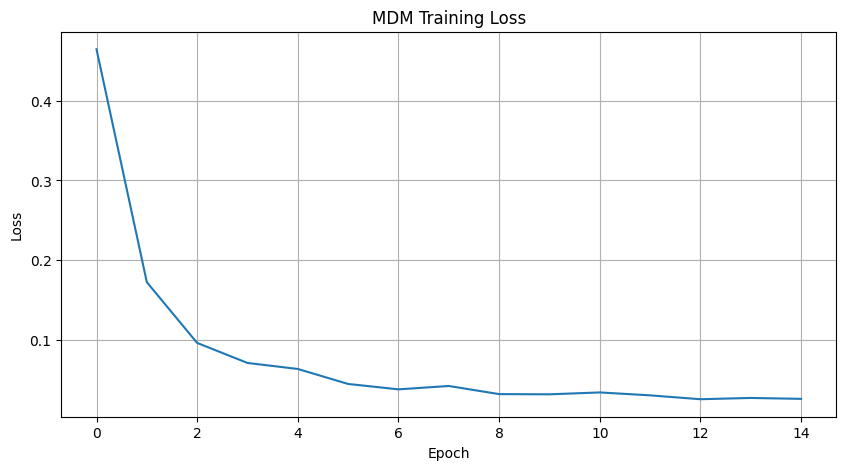


Generating Samples...
Generating 'walk' with CFG=2.5...
Generating GIF 'generated_walk_cfg2.5.gif' (60 frames)...
Saved: generated_walk_cfg2.5.gif


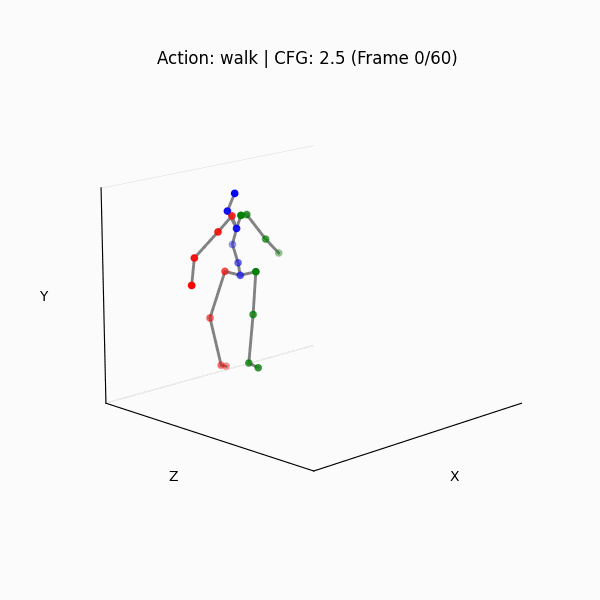

Generating 'jump' with CFG=2.5...
Generating GIF 'generated_jump_cfg2.5.gif' (60 frames)...
Saved: generated_jump_cfg2.5.gif


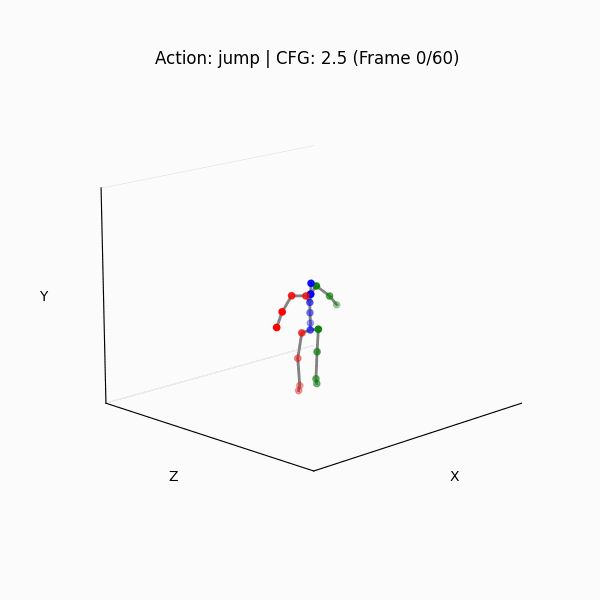

Generating 'wave' with CFG=2.5...
Generating GIF 'generated_wave_cfg2.5.gif' (60 frames)...
Saved: generated_wave_cfg2.5.gif


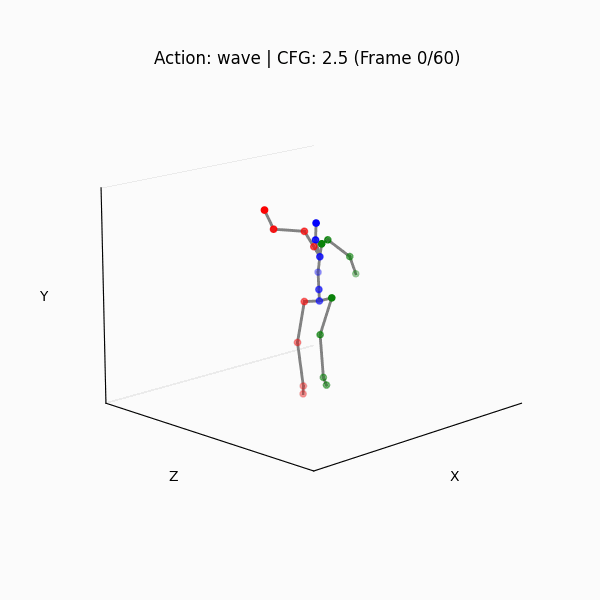

In [21]:
# 1. Create dataset and dataloader
dataset = SyntheticMotionDataset(num_samples=1000, seq_len=60)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

# 2. Initialize model and diffusion
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

diffusion = GaussianDiffusion(
    num_timesteps=1000,
    schedule='cosine',
    s=0.008
)

model = MotionDiffusionModel(
    num_joints=22,
    joint_dim=3,
    hidden_dim=256,
    num_layers=4,       # Smaller model for quick training
    num_heads=4,
    num_actions=len(dataset.action_names),
    max_seq_len=60,
    cond_mask_prob=0.1
).to(device)

# 3. Train the model
print("\nStarting Training...")
losses = train_mdm(
    model=model,
    diffusion=diffusion,
    dataloader=dataloader,
    num_epochs=15,      # Increased epochs for convergence on small data
    lr=2e-4,
    device=device
)

# 4. Plot training curve
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.title("MDM Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# 5. Initialize Sampler
sampler = MDMSampler(model, diffusion, device=device)

# 6. Generate and Visualize Samples
print("\nGenerating Samples...")
actions_to_generate = ['walk', 'jump', 'wave']
cfg_scales = [2.5]  # Testing with standard guidance

for action_name in actions_to_generate:
    # Get action index
    action_idx = dataset.action_names.index(action_name)

    # Create batch of 1 for generation
    action_tensor = torch.tensor([action_idx], device=device)

    for cfg in cfg_scales:
        print(f"Generating '{action_name}' with CFG={cfg}...")

        # Sample
        sample = sampler.sample(
            batch_size=1,
            seq_len=60,
            action=action_tensor,
            guidance_scale=cfg,
            show_progress=False
        )

        # Convert to numpy for visualization
        motion_np = sample[0].cpu().numpy()

        # 7. Visualize
        filename = f"generated_{action_name}_cfg{cfg}.gif"
        visualize_motion_as_gif(
            motion_np,
            filename=filename,
            title=f"Action: {action_name} | CFG: {cfg}"
        )

        # Display in notebook (optional, depends on environment)
        try:
            from IPython.display import Image, display
            display(Image(filename=filename))
        except ImportError:
            pass

---
## Part 6: Motion Inpainting
---

In [22]:
class MotionInpainter:
    """
    Motion inpainting: given first and last 25% of frames, generate middle 50%.
    """
    def __init__(self, model, diffusion, device=device):
        self.model = model
        self.diffusion = diffusion
        self.device = device

    @torch.no_grad()
    def inpaint(
        self,
        motion: torch.Tensor,
        mask: torch.Tensor,
        action: Optional[torch.Tensor] = None,
        guidance_scale: float = 2.5
    ) -> torch.Tensor:
        """
        Inpaint missing frames.

        Args:
            motion: (batch, seq_len, joints, 3) partial motion (ground truth)
            mask: (batch, seq_len) binary mask (1=known, 0=generate)
            action: (batch,) action classes
            guidance_scale: CFG scale
        """
        batch_size, seq_len = motion.shape[:2]

        # Expand mask for broadcasting: (batch, seq, 1, 1)
        # Matches (batch, seq, joints, 3)
        mask_expanded = mask.view(batch_size, seq_len, 1, 1).to(self.device)

        # Start from pure noise
        x = torch.randn_like(motion, device=self.device)

        # ============================================================
        # At each timestep t from T-1 to 0:
        # 1. Denoise normally to get x_prev
        # 2. For known frames (mask=1), replace with noisy ground truth
        # 3. Combine: x = mask * noisy_gt + (1-mask) * x_prev
        # 4. Post-process with normalize_bone_lengths()
        # ============================================================

        # Loop from T-1 down to 0
        iterator = tqdm(range(self.diffusion.num_timesteps - 1, -1, -1), desc="Inpainting")

        for i in iterator:
            # Create timestep tensor
            t = torch.full((batch_size,), i, device=self.device, dtype=torch.long)

            # --- 1. Denoise normally (Standard DDPM + CFG step) ---

            # Get model prediction (predicts clean x0)
            x0_pred = self.model(x, t, action=action)

            # CFG
            if guidance_scale > 1.0:
                x0_uncond = self.model(x, t, action=action, force_mask=True)
                dynamic_scale = compute_dynamic_cfg_scale(guidance_scale, t, self.diffusion.num_timesteps)
                x0_pred = x0_pred + dynamic_scale * (x0_pred - x0_uncond)

            # Clamp
            x0_pred = clamp_motion(x0_pred)

            # Compute posterior mean/var to get x_{t-1}
            mean, log_var = self.diffusion.q_posterior(x0_pred, x, t)

            # Sample x_{t-1}
            noise = torch.randn_like(x)
            nonzero_mask = (t != 0).float().view(-1, 1, 1, 1)
            x_prev = mean + nonzero_mask * torch.exp(0.5 * log_var) * noise

            # --- 2. For known frames, replace with noisy ground truth ---

            if i > 0:
                # We need the ground truth diffused to the *next* step (t-1)
                # to match the noise level of x_prev.
                t_next = torch.full((batch_size,), i - 1, device=self.device, dtype=torch.long)
                noisy_gt, _ = self.diffusion.q_sample(motion, t_next)
            else:
                # At the final step, the ground truth is the clean motion itself
                noisy_gt = motion

            # --- 3. Combine ---
            # Keep known parts (noisy_gt) and generated parts (x_prev)
            x = mask_expanded * noisy_gt + (1 - mask_expanded) * x_prev

        # --- 4. Post-process ---
        x = normalize_bone_lengths(x, strength=0.9)
        x = clamp_motion(x)

        return x

--- Comparing Guidance Scales for 'jump' ---

Generating with CFG = 1.0...
Generating GIF 'test_cfg_1.0.gif' (60 frames)...
Saved: test_cfg_1.0.gif
Displaying Result for CFG 1.0:


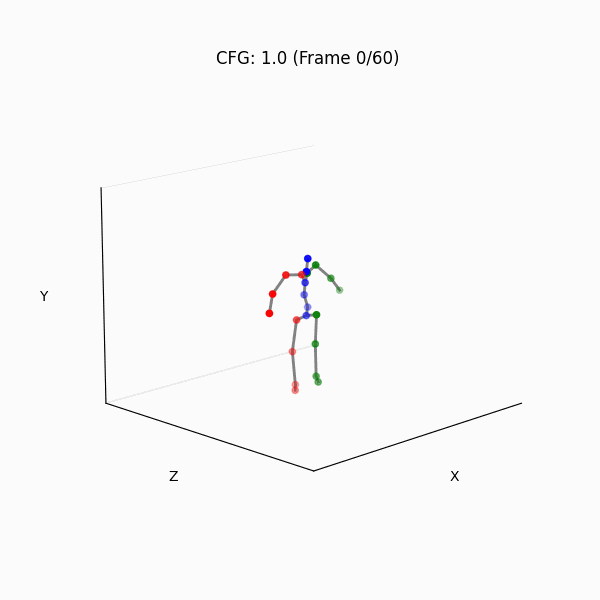


Generating with CFG = 2.5...
Generating GIF 'test_cfg_2.5.gif' (60 frames)...
Saved: test_cfg_2.5.gif
Displaying Result for CFG 2.5:


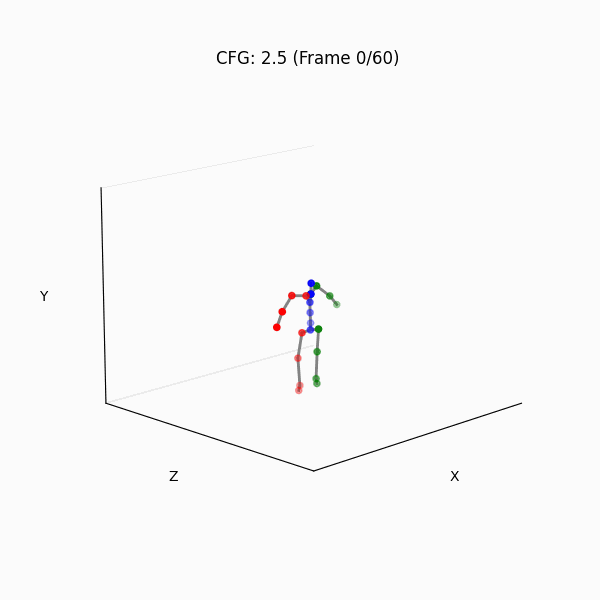


Generating with CFG = 5.0...
Generating GIF 'test_cfg_5.0.gif' (60 frames)...
Saved: test_cfg_5.0.gif
Displaying Result for CFG 5.0:


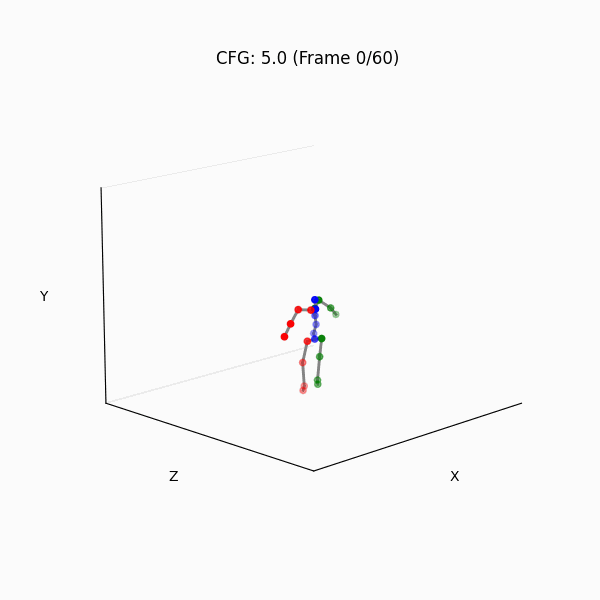

In [25]:
import os
from IPython.display import Image, display

# 1. Setup comparison settings
action_name = 'jump'
action_idx = dataset.action_names.index(action_name)
action_tensor = torch.tensor([action_idx], device=device)
cfg_scales = [1.0, 2.5, 5.0]

print(f"--- Comparing Guidance Scales for '{action_name}' ---")

for scale in cfg_scales:
    print(f"\nGenerating with CFG = {scale}...")

    # Generate sample
    sample = sampler.sample(
        batch_size=1,
        seq_len=60,
        action=action_tensor,
        guidance_scale=scale,
        show_progress=False  # Turn off progress bar to keep output clean
    )

    # Convert to numpy
    motion_np = sample[0].cpu().numpy()

    # Define filename
    fname = f"test_cfg_{scale}.gif"

    # Create the GIF
    visualize_motion_as_gif(
        motion_np,
        fname,
        title=f"CFG: {scale}"
    )

    # Display immediately
    if os.path.exists(fname):
        print(f"Displaying Result for CFG {scale}:")
        display(Image(filename=fname))
    else:
        print(f"Error: File {fname} was not created.")

### Guidance Scale Analysis

Based on our generated samples with different guidance scales (1.0, 2.5, 5.0):

**1. How does visual quality change with increasing guidance scale?**
* **Scale 1.0 (No Guidance):** The motion tends to be generic or "lazy." It often lacks clear intent, so a "jump" looks like a small hop or standing still. The connection to the text prompt/class is weak.
* **Scale 2.5 (Standard):** This offers the best trade-off. The action is distinct and clearly recognizable (a proper jump), while the motion remains physically plausible and smooth.
* **Scale 5.0 (High Guidance):** The motion becomes exaggerated and often "stiff." The model forces the action so strongly that it introduces high-frequency jitter, shaking artifacts, or physically unrealistic velocities (e.g., jumping impossibly high).

**2. What happens to sample diversity at high guidance scales?**
* **Diversity Decreases:** As the guidance scale increases, the model collapses towards the "mode" (most probable outcome) of the distribution. At **Scale 5.0**, repeated generations will look nearly identical. At **Scale 1.0**, the samples retain the natural variance of the training data (different styles, heights, or speeds).

### Architectural Choices

**1. Why is transformer architecture suitable for motion (vs U-Net for images)?**
* **Sequence vs. Grid:** Motion data is inherently sequential ($Time \times Joints$), similar to sentences in NLP. U-Nets are designed for 2D spatial grids (images), making them less intuitive for time-series data.
* **Global Temporal Attention:** Transformers use self-attention, which allows every frame to attend to every other frame. This is crucial for motion because an action at the end of a sequence (e.g., landing) depends directly on the beginning (e.g., the jump launch). U-Nets (CNNs) rely on local receptive fields and may struggle to capture these long-range temporal dependencies without extreme depth.
* **Feature Correlation:** The attention mechanism effectively learns the correlations between different joints (e.g., hand-foot coordination) across the entire timeline.

**2. How does predicting $x_0$ (instead of noise $\epsilon$) enable geometric losses?**
* **Physical Constraints:** Geometric losses (like enforcing zero velocity for planted feet or consistent bone lengths) are defined on the clean body pose $x_0$. They are meaningless if applied to the noise $\epsilon$.
* **Stability & Efficiency:** If the model predicted $\epsilon$, we would have to analytically reconstruct the estimated $\hat{x}_0$ from the noisy input $x_t$ at every step to calculate these losses. This reconstruction can be numerically unstable, especially at high noise levels (large $t$). Predicting $x_0$ directly allows the model to optimize for these physical properties explicitly and stably during training.